In [13]:
# uncomment this to enable jax gpu preallocation, might lead to memory issues

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from typing import Sequence, List, Tuple, Optional

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import gym

from hypernn.jax.utils import count_jax_params


In [4]:
from hypernn.jax.hypernet import JaxHyperNetwork

#### Target Policy Network

In [5]:
class MLP(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256, use_bias=False)(x)
        x = nn.tanh(x)
        x = nn.Dense(256, use_bias=False)(x)
        x = nn.tanh(x)
        x = nn.Dense(4, use_bias=False)(x)
        return x

In [6]:
target_network = MLP()

count_jax_params(target_network, inputs=jnp.zeros((1,8)))

68608

#### Making a Lunar Lander Hypernetwork with a Custom Weight Generator

In [7]:
from typing import Any, Dict, List, Optional, Tuple, Type, Union  # noqa
import flax.linen as nn

class LunarLanderHypernetwork(JaxHyperNetwork):

    def make_weight_generator(self):
        return nn.Sequential(
            [
                nn.Dense(32),
                nn.tanh,
                nn.Dense(self.weight_chunk_dim)
            ]
        )


### We can reduce the number of trainable parameters to less than 10%

In [8]:
EMBEDDING_DIM = 4
NUM_EMBEDDINGS = 512

hypernetwork = LunarLanderHypernetwork.from_target(
    target_network = target_network,
    embedding_dim = EMBEDDING_DIM,
    num_embeddings = NUM_EMBEDDINGS,
    inputs=jnp.zeros((1,8))
)
count_jax_params(hypernetwork, inputs=[jnp.zeros((1,8))])

6630

#### Tensorboard utils

In [9]:
import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def get_tensorboard_logger(
    experiment_name: str, base_log_path: str = "tensorboard_logs"
):
    log_path = "{}/{}_{}".format(base_log_path, experiment_name, datetime.now())
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: python -m tensorboard.main --logdir '{}'".format(full_log_path)
    )
    return train_writer


#### Rollout function

In [25]:
from tensorflow_probability.substrates import jax as tfp

import jax
import functools

@functools.partial(jax.jit, static_argnames=('apply_fn', 'method'))
def generate_params(apply_fn, hypernetwork_params, method):
    generated_params, _ = apply_fn({'params':hypernetwork_params}, method=method)
    return generated_params

@functools.partial(jax.jit, static_argnames=('apply_fn'))
def sample_actions(apply_fn, hypernetwork_params, obs, generated_params):
    out =  apply_fn({'params':hypernetwork_params}, inp=[jnp.expand_dims(jnp.array(obs), 0)], generated_params=generated_params, has_aux=False)
    return out

def rollout(env, apply_fn, generate_params_fn, hypernetwork_params, render=False, seed: int = 0) -> float:
    obs = env.reset()
    done = False
    observations, actions, rewards, rendereds = [], [], [], []
    generated_params = generate_params(apply_fn, hypernetwork_params, generate_params_fn)
    while not done:
        rendered = None
        if render:
            rendered = env.render(mode="rgb_array")
            rendereds.append(rendered)

        out = sample_actions(apply_fn, hypernetwork_params, obs, generated_params)
        out = jnp.squeeze(out)
        dist = tfp.distributions.Categorical(logits=out)
        rng = jax.random.PRNGKey(np.random.randint(0, 10**10))
        action = dist.sample(seed=rng).item()

        next_obs, r, done, _ = env.step(action)

        observations.append(obs)
        actions.append(action)
        rewards.append(r)

        obs = next_obs

    num_steps = len(observations)
    env.close()
    return observations, actions, rewards, rendereds, num_steps

#### Reinforce algorithm

In [26]:
import optax
from flax.training import train_state  # Useful dataclass to keep train state

def create_train_state(rng, hypernetwork, learning_rate, input_shape):
    """Creates initial `TrainState`."""
    params = hypernetwork.init(rng, [jnp.ones(input_shape)])['params']
    # Exponential decay of the learning rate.
    scheduler = optax.exponential_decay(
        init_value=learning_rate, 
        transition_steps=1000,
        decay_rate=0.99)

    tx = optax.chain(
        optax.clip_by_global_norm(100.0),
        # optax.scale_by_adam(),  # Use the updates from adam.
        # optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
        # # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
        # optax.scale(-1.0)
        optax.adam(learning_rate)
    )
    return train_state.TrainState.create(
        apply_fn=hypernetwork.apply, params=params, tx=tx)

@functools.partial(jax.jit, static_argnames=('apply_fn'))
def train_step(apply_fn, state, observations, actions, discounted_rewards):
    def loss_fn(params):
        logits = apply_fn({'params':params}, inp=[observations], has_aux=False)
        dist = tfp.distributions.Categorical(logits=jnp.squeeze(logits))
        log_probs = jnp.squeeze(dist.log_prob(actions))
        loss = jnp.sum(discounted_rewards * log_probs)
        return -1*loss
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    return state.apply_gradients(grads=grads), loss, grads

import pandas as pd
import tqdm

def flatten(d):
    df = pd.json_normalize(d, sep='_')
    return df.to_dict(orient='records')[0]

def discount_reward(rews, gamma: float = 0.99):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + gamma*(rtgs[i + 1] if i + 1 < n else 0)
    return rtgs

def reinforce(
        num_epochs,
        env,
        hypernetwork,
        seed: int = 0,
        lr: float = 0.0001,
        gamma: float = 0.99,
    ):
    writer = get_tensorboard_logger("HypernetworkJaxRL")

    rng = jax.random.PRNGKey(seed)
    rng, init_rng = jax.random.split(rng)
    state = create_train_state(init_rng, hypernetwork, lr, (1,8))

    bar = tqdm.tqdm(np.arange(num_epochs))

    try:
        for i in bar:
            observations, actions, rewards, _, num_steps = rollout(env, hypernetwork.apply, hypernetwork.generate_params, state.params, seed=seed)
            discounted_rewards = discount_reward(np.array(rewards), 0.99)
            discounted_rewards = discounted_rewards - np.mean(discounted_rewards)
            discounted_rewards = discounted_rewards / (
                np.std(discounted_rewards) + 1e-10
            )

            observations = jnp.array(observations)
            actions = jnp.array(actions)
            discounted_rewards = jnp.array(discounted_rewards)

            state, loss, grads = train_step(hypernetwork.apply, state, observations, actions, discounted_rewards)
            grad_dict = {k:dict(grads[k]) for k in grads.keys()}
            grad_dict = flatten(grad_dict)

            grad_dict = {k: {kk: np.sum(vv).item() for kk, vv in v.items()}
                        for k, v in grad_dict.items()}
            grad_dict = flatten(grad_dict)

            metrics = {"loss":loss.item(), "rewards":np.sum(rewards), "num_steps":num_steps, **grad_dict}

            for key in metrics:
                writer.add_scalar(key, metrics[key], i)

            bar.set_description('Loss: {}, Sum Reward: {}'.format(loss.item(), np.sum(rewards)))
        return hypernetwork, state
    except KeyboardInterrupt as e:
        return hypernetwork, state


In [27]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [28]:
import gym

env = gym.make("LunarLander-v2")

In [29]:
hyper, state = reinforce(5000, env, hypernetwork, seed=10, lr=0.0001)

Follow tensorboard logs with: python -m tensorboard.main --logdir '/home/shyam/Code/hyper-nn/notebooks/reinforce/tensorboard_logs/HypernetworkJaxRL_2022-05-24 20:01:06.074723'


Loss: 6.261016845703125, Sum Reward: 6.910303700857327: 100%|████████| 5000/5000 [40:58<00:00,  2.03it/s]


In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib ipympl

plt.style.use('ggplot')
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from celluloid import Camera
from IPython.display import HTML


def render_rollout(model, state, seed=10):
    fig = plt.figure("Animation",figsize=(7,5))
    camera = Camera(fig)
    ax = fig.add_subplot(111)
    observations, actions, rewards, rendereds, num_steps = rollout(gym.make("LunarLander-v2"), model.apply, model.generate_params, state.params, seed=seed)
    frames = []
    for r in rendereds:
        frame = ax.imshow(r)
        ax.axis('off')
        camera.snap()
        frames.append([frame])
    print("Sum Reward: {}".format(np.sum(rewards)))
    animation = camera.animate(blit=False, interval=50)
    # display(animations.to_html5_video())
    animation.save('HyperJaxLunarLander.mp4')
    return animation

Sum Reward: -39.431708010290734


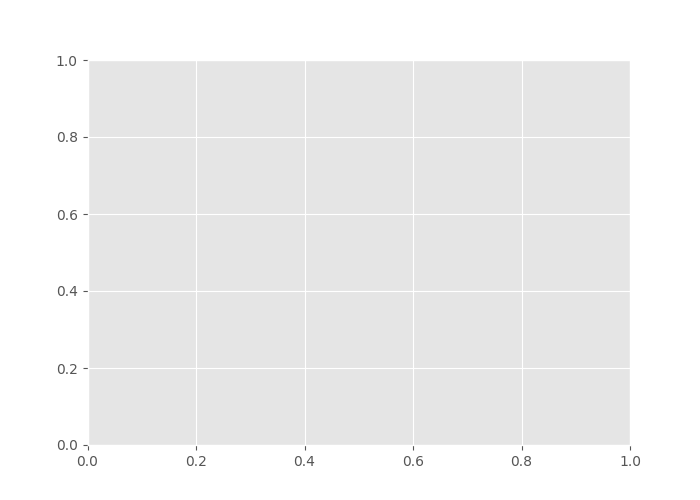

In [37]:
vid = render_rollout(hypernetwork, state, seed=10)

##### Play video

In [ ]:
from IPython.display import Video

Video("HyperJaxLunarLander.mp4")